In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 20*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-02 16:38:46.722804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 16:38:46.917766: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-02 16:38:47.567270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_names = ["Koch_Meinhardt_1", "Koch_Meinhardt_2", "Koch_Meinhardt_3",
             "Koch_Meinhardt_4", "Koch_Meinhardt_5",
             "Koch_Meinhardt_6", "Koch_Meinhardt_7", "Koch_Meinhardt_9"]
sim_name = sim_names[1]
x_slice=slice(0,99,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,99,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:
class NN_Field(tu.NN_base):
    def __init__(self, x_range, y_range, depth, dim_2d, layer_num, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.depth = depth
        self.layer_num = layer_num
        self.dim_2d = dim_2d
        x = tf.constant(x_range, dtype=dtype)
        y = tf.constant(y_range, dtype=dtype)
        #Y,X = tf.meshgrid(x, y, indexing='ij')
        #X, Y = tf.meshgrid(x, y)
        Y, X = tf.meshgrid(x, y)
        self.X = X
        self.Y = Y
        self.domain_shape = X.shape
        self.build()
        
    def make_variables(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))
    
                           
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        scales = []
        biases = []
        
        rnd_init = tf.random_normal_initializer(stddev=1/6)
        W = tf.Variable(self.make_variables([self.depth, 3], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)
        for i in range(self.layer_num-1):
            rnd_init = tf.random_normal_initializer(stddev=1/(2*self.depth))
            W = tf.Variable(self.make_variables([self.depth, self.depth], rnd_init)
                        , dtype=self.dtype)
            #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
            a = tf.Variable(tf.ones([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
            weights.append(W)
            scales.append(a)
            biases.append(b)
            
        rnd_init = tf.random_normal_initializer(stddev=1/4)
        W = tf.Variable(self.make_variables([2, self.depth], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([2, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)

        self.Ws = weights
        self.scales = scales
        self.bs = biases

    def make_inputs(self, ts):
        T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]       
        return T
        
    @tf.function
    def net(self, T):
        #T = tf.fill(self.domain_shape, t)
#         H = tf.concat([tf.expand_dims(self.X, 0), 
#                        tf.expand_dims(self.Y, 0), 
#                        tf.expand_dims(T, 0)], axis=0)
    

    
         
        
        #T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]
        #print(T)
        # H will be a tensor (batches, m, n, 3)
        # where batches is the len of ts,
        #       m,n are the width and hieght of the domain
        #       and 3 is for x,y,t
        H = tf.concat([tf.concat([self.X[tf.newaxis, :, :, tf.newaxis], 
                                 self.Y[tf.newaxis, :, :, tf.newaxis],
                                 T[:, :, i:i+1][tf.newaxis, :, :, :]], axis=3) for i in range(T.shape[-1])], axis=0)
        #print(H)
        def act(x):
            return x*tf.sigmoid(x)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            #print(W)
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #outputs =  mul_outputs + b
            #print(outputs)
            #H = tf.tanh(outputs)
            #H = tf.sigmoid(outputs)
            H = act(outputs)
            #print(H)

        return outputs
    
    @tf.function
    def net2(self, t):                
        T = tf.fill(self.domain_shape, t)
        
        H = tf.concat([tf.expand_dims(self.X, 0), 
                       tf.expand_dims(self.Y, 0), 
                       tf.expand_dims(T, 0)], axis=0)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            mul_outputs = tf.tensordot(W, H, axes=[[0], [0]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #print(outputs)
            H = tf.tanh(outputs)
            #print(H)

        return outputs

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2



In [5]:
#@tf.function
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(pinn.X)
        tape.watch(pinn.Y)        
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(ts)
            tape2.watch(T)     
            
            outputs = pinn.net(T)
        
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
        u_x = tape2.gradient(u, pinn.X)
        u_y = tape2.gradient(u, pinn.Y)
        u_t = tape2.gradient(u, T)
        v_x = tape2.gradient(v, pinn.X)
        v_y = tape2.gradient(v, pinn.Y)
        v_t = tape2.gradient(v, T)
            
    u_xx = tape.gradient(u_x, pinn.X)
    u_xy = tape.gradient(u_x, pinn.Y)
    u_yx = tape.gradient(u_y, pinn.X)
    u_yy = tape.gradient(u_y, pinn.Y)
    v_xx = tape.gradient(v_x, pinn.X)
    v_yy = tape.gradient(v_y, pinn.Y)
    v_xy = tape.gradient(v_x, pinn.Y)
    v_yx = tape.gradient(v_y, pinn.X)
    #return (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t)
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))


In [6]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [7]:
pattern.t_star.shape

(12,)

In [20]:

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

optimizer=keras.optimizers.Adam(learning_rate=2e-4)
pinn = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()

init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn.X)
        tape.watch(pinn.Y)
        #tape.watch(t)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(elements[0])
            tape2.watch(T)
            
            outputs = pinn.net(T)            
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
            u_x = tape2.gradient(u, pinn.X)
            u_y = tape2.gradient(u, pinn.Y)
            u_t = tape2.gradient(u, T)
            u_t = tf.squeeze(tf.einsum("ijt -> tij", u_t))
            
            v_x = tape2.gradient(v, pinn.X)
            v_y = tape2.gradient(v, pinn.Y)
            v_t = tape2.gradient(v, T)
            v_t = tf.squeeze(tf.einsum("ijt -> tij", v_t))
            
        
        u_xx = tape.gradient(u_x, pinn.X)
        u_xy = tape.gradient(u_x, pinn.Y)
        u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn.Y)
        v_xx = tape.gradient(v_x, pinn.X)
        v_yy = tape.gradient(v_y, pinn.Y)
        v_xy = tape.gradient(v_x, pinn.Y)
        v_yx = tape.gradient(v_y, pinn.X)
        
               
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        
        #print(u.shape)
        #print(u_xx.shape)
        u_xyyx_diff = u_xy - u_yx
        v_xyyx_diff = v_xy - v_yx

        #diff = outputs - elements[1] 
        #print(elements[1].shape)
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v + l2_res_u_xyyx + l2_res_v_xyyx
        
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer.apply_gradients(zip(grads, trainables + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v, l2_res_u_xyyx, l2_res_v_xyyx)


In [21]:
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n"
            f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=50000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 297636.96875 u: 258682.640625, v: 236.3051300048828,
 Res u: 38334.546875, Res v: 383.4655456542969 
 Res u xyyx: 5.28279120350222e-22, Res v xyyx: 2.9273978171365846e-23
rho_u: 1.998297095298767, rho_v: 0.05155916139483452 
sigma_u: 1.9976009130477905, sigma_v: 0.19760112464427948 
kappa_u: 0.00021863364963792264, mu_u: 2.001840591430664 

Time taken: 21.41s

Start of epoch 1000
at epoch 1000
 total loss: 13723.751953125 u: 13689.634765625, v: 9.335756301879883,
 Res u: 24.373645782470703, Res v: 0.4069400727748871 
 Res u xyyx: 2.2964555682847276e-05, Res v xyyx: 8.244602334173123e-09
rho_u: 1.9923096895217896, rho_v: 0.02434648759663105 
sigma_u: 2.0466158390045166, sigma_v: 0.09520246088504791 
kappa_u: 0.007188605144619942, mu_u: 1.9641093015670776 

Time taken: 460.61s

Start of epoch 2000
at epoch 2000
 total loss: 11784.7314453125 u: 11709.283203125, v: 8.362993240356445,
 Res u: 66.57352447509766, Res v: 0.5121755599975586 
 Res u xyyx


Start of epoch 20000
at epoch 20000
 total loss: 79.54679107666016 u: 56.1065673828125, v: 1.2667515277862549,
 Res u: 21.639690399169922, Res v: 0.5283551216125488 
 Res u xyyx: 0.005423199385404587, Res v xyyx: 1.1825583356994684e-07
rho_u: 1.9629154205322266, rho_v: 0.005652229301631451 
sigma_u: 2.2816593647003174, sigma_v: 0.01919793337583542 
kappa_u: 0.00796133279800415, mu_u: 1.7613015174865723 

Time taken: 517.28s

Start of epoch 21000
at epoch 21000
 total loss: 105.54618835449219 u: 82.0520248413086, v: 1.1908822059631348,
 Res u: 21.79120635986328, Res v: 0.5070438385009766 
 Res u xyyx: 0.005038712173700333, Res v xyyx: 1.1791943421712858e-07
rho_u: 1.9568735361099243, rho_v: 0.006461718585342169 
sigma_u: 2.2742197513580322, sigma_v: 0.021600693464279175 
kappa_u: 0.007764178328216076, mu_u: 1.76199471950531 

Time taken: 502.01s

Start of epoch 22000
at epoch 22000
 total loss: 71.71775817871094 u: 54.81849670410156, v: 0.8579934239387512,
 Res u: 15.6183443069458, Res


Start of epoch 40000
at epoch 40000
 total loss: 10.777495384216309 u: 6.8009467124938965, v: 0.12090360373258591,
 Res u: 3.571011543273926, Res v: 0.2806241512298584 
 Res u xyyx: 0.004009204916656017, Res v xyyx: 3.5631018135973136e-07
rho_u: 1.8239821195602417, rho_v: 0.021327326074242592 
sigma_u: 2.2498326301574707, sigma_v: 0.07838968187570572 
kappa_u: 0.003016323084011674, mu_u: 1.797852635383606 

Time taken: 572.02s

Start of epoch 41000
at epoch 41000
 total loss: 38.982635498046875 u: 35.738990783691406, v: 0.13414780795574188,
 Res u: 2.8353638648986816, Res v: 0.27019810676574707 
 Res u xyyx: 0.003933422267436981, Res v xyyx: 3.440997602410789e-07
rho_u: 1.8205512762069702, rho_v: 0.02120775729417801 
sigma_u: 2.250187397003174, sigma_v: 0.07871134579181671 
kappa_u: 0.003012009197846055, mu_u: 1.7970777750015259 

Time taken: 565.30s

Start of epoch 42000
at epoch 42000
 total loss: 23.62071418762207 u: 21.075422286987305, v: 0.12825484573841095,
 Res u: 2.15324592590

In [ ]:
'rho_u': 1.0,  'rho_v': 0.025,
'sigma_u': 1.0, 'sigma_v': 0.1,
'kappa_u': 0.0, 'mu_u': 1.0,

In [42]:
pinn.save(pinn, ".", "pinn_2D_Koch_Meinhardt_2")

In [25]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 1.6761629420571418
V params. estimates: 0.22446879412578635


In [22]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 1.0,
 'mu_u': 1.0,
 'sigma_u': 1.0,
 'rho_v': 0.025,
 'sigma_v': 0.1}

In [26]:
def sum_per(arr, element_nums_by=2):
    return np.sum(arr.reshape(-1, element_nums_by), axis=1)

losses2 = np.array(losses )
element_nums_by = 12#len(losses)//2
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],                        
                        ], axis=1)

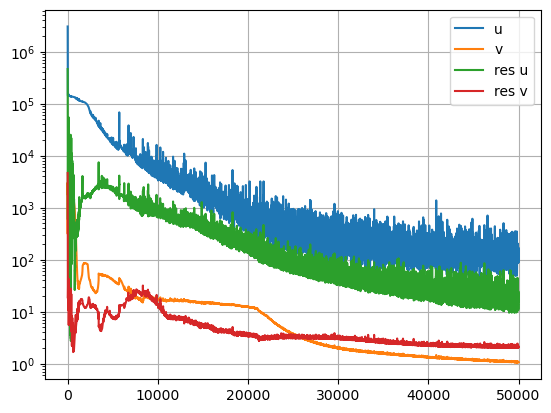

In [27]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [28]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))

In [72]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    #return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
    return np.sqrt(np.mean(((arr1-arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.03234292
v:  0.0032529973
u_xx:  0.17432253
v_xx:  0.006053983
u_yy:  0.18036652
v_yy:  0.0061041163
u_t:  0.0026203042
v_t:  4.5952638e-05


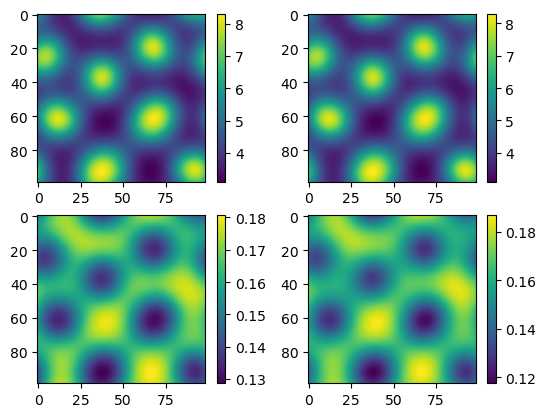

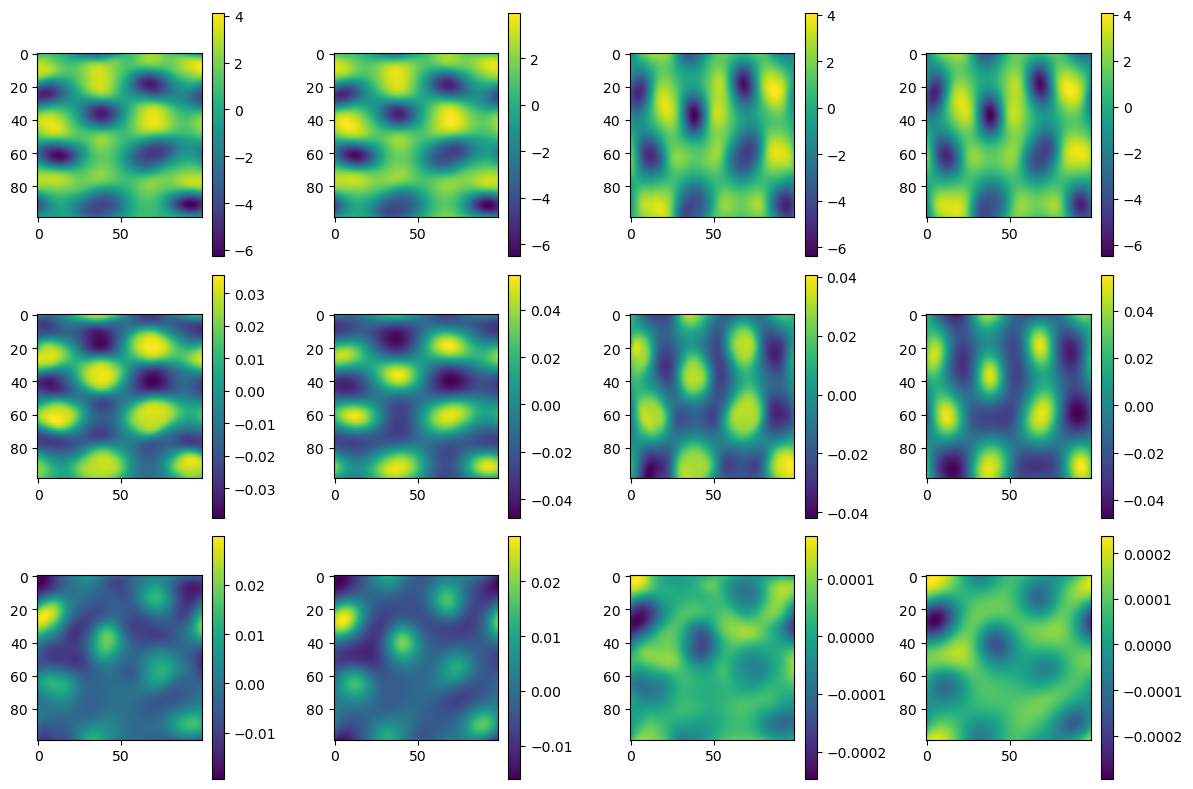

In [76]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [298]:
def grads(pinn, ts):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(pinn.X)
        tape.watch(pinn.Y)        
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(ts)
            tape2.watch(T)     
            
            outputs = pinn.net(T)
        
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
        u_x = tape2.gradient(u, pinn.X)
        u_y = tape2.gradient(u, pinn.Y)
        u_t = tape2.gradient(u, T)
        v_x = tape2.gradient(v, pinn.X)
        v_y = tape2.gradient(v, pinn.Y)
        v_t = tape2.gradient(v, T)
            
    u_xx = tape.gradient(u_x, pinn.X)
    u_yy = tape.gradient(u_y, pinn.Y)
    v_xx = tape.gradient(v_x, pinn.X)
    v_yy = tape.gradient(v_y, pinn.Y)
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))

def loss(pinn, ts, rho_u, rho_v, sigma_u, sigma_v, mu_u, kappa_u):    
    (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, ts)
    D_u = pattern.params["D_u"]
    D_v = pattern.params["D_v"]
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    
    return tf.reduce_sum(f_u**2), tf.reduce_sum(f_v**2)


def loss_u(pinn, ts, rho_u, sigma_u, mu_u, kappa_u):    
    (u, u_xx, u_yy, u_t, v, _, _, _) = grads(pinn, ts)
    D_u = pattern.params["D_u"]    
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    return tf.reduce_sum(f_u**2)

def loss_v(pinn, ts, rho_v, sigma_v, kappa_u):    
    (u, _, _, _, v, v_xx, v_yy, v_t) = grads(pinn, ts)
    D_v = pattern.params["D_v"]
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    
    return tf.reduce_sum(f_v**2)    

In [375]:
def Euc_L(vec):
    return np.sqrt(np.sum(vec**2))

def normalise(vec):
    return vec/(Euc_L(vec) + 1e-100)

def creat_line(x_0, s):
    def line(alpha):
        return x_0 + alpha * s
    return line

s_u = normalise(u_vec - u_vec_ac)
s_v = normalise(v_vec - v_vec_ac)

s_u_line = creat_line(u_vec_ac, s_u)
s_v_line = creat_line(v_vec_ac, s_v)

alpha_u_end = Euc_L(u_vec - u_vec_ac)
alpha_v_end = Euc_L(v_vec - v_vec_ac)

In [406]:
alpha_u_end

1.6761629420571418

In [407]:
u_line_alphas = np.linspace(-10*alpha_u_end, 10*alpha_u_end, 200)
v_line_alphas = np.linspace(-10*alpha_v_end, 10*alpha_v_end, 200)

u_line_params = np.array([ s_u_line(alpha) for alpha in u_line_alphas])
v_line_params = np.array([ s_v_line(alpha) for alpha in v_line_alphas])

In [408]:
u_line_losses = np.array([loss_u(pinn, pattern.t_star[-1:].astype(np.float32), *params) 
                          for params in u_line_params])
v_line_losses = np.array([loss_v(pinn, pattern.t_star[-1:].astype(np.float32), *params) 
                          for params in v_line_params])

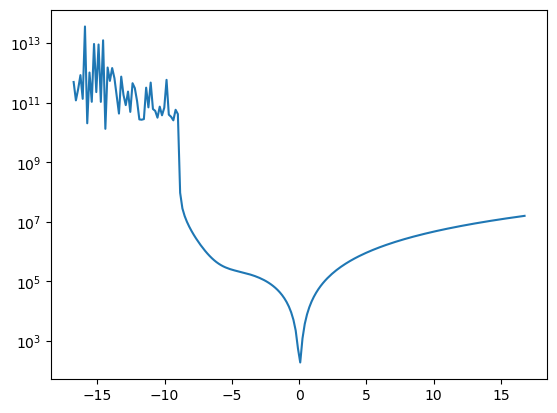

In [411]:
plt.plot(u_line_alphas, u_line_losses)
plt.yscale('log')

In [413]:
s_u_line(-12)

array([-4.69678842, -4.64007791, -7.92948725, -0.01950434])

In [414]:
s_v_line(-0.15)

array([ 0.04933713,  0.24646514, -0.02134635])

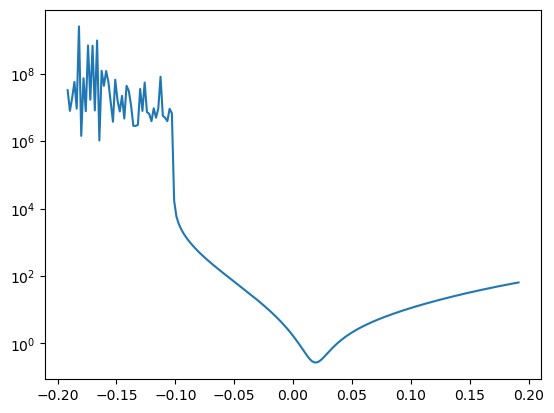

In [412]:
plt.plot(v_line_alphas, v_line_losses)
plt.yscale('log')

In [77]:
from scipy.optimize import lsq_linear
from scipy import linalg

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

params2 = np.concatenate([u_vec[:-1], v_vec[:-1]])
params3 = np.concatenate([u_vec_ac[:-1], v_vec_ac[:-1]])

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()
n2 = u_sol.shape[0]
kappa_sol = kappa_u.numpy()#pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = D_u.numpy()*(u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = D_v.numpy()*(v_xx.numpy() + v_yy.numpy()).flatten()

A_sol =  np.vstack((np.c_[f_sol,  u_sol,  [1]*n2, [0]*n2, [0]*n2],
                    np.c_[[0]*n2, [0]*n2, [0]*n2,-f_sol,  [1]*n2]))


u_dt_sol = (u_t.numpy()).flatten()
v_dt_sol = (v_t.numpy()).flatten()

b_sol =  np.r_[(u_dt_sol-uxxyy_sol, v_dt_sol-vxxyy_sol)]

In [78]:
np.sqrt(np.mean(((np.dot(A_sol, params2)-b_sol))**2))

13.008378744298266

In [79]:
np.sqrt(np.mean(((np.dot(A_sol, params3)-b_sol))**2))

7.061522720170612

In [46]:
import copy as cp

In [138]:
pinn_copy = cp.deepcopy(pinn)

In [337]:
sigma_u2 = tf.Variable(sigma_u.numpy(),
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v2 = tf.Variable(sigma_v.numpy(),
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u2 = tf.Variable(mu_u.numpy(),
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u2 = tf.Variable(rho_u.numpy(),
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v2 = tf.Variable(rho_v.numpy(),
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u2 = tf.Variable(0.0,#kappa_u.numpy(),
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf2 = (sigma_u2, sigma_v2, mu_u2, rho_u2, rho_v2)#, kappa_u2,)


optimizer2=keras.optimizers.Adam(learning_rate=1e-3)


@tf.function
def train_step_inverse_param(elements, pinn):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn.X)
        tape.watch(pinn.Y)
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            
            T = pinn.make_inputs(elements)#[0])
            tape2.watch(T)
            
            outputs = pinn.net(T)            
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
            u_x = tape2.gradient(u, pinn.X)
            u_y = tape2.gradient(u, pinn.Y)
            u_t = tape2.gradient(u, T)
            u_t = tf.squeeze(tf.einsum("ijt -> tij", u_t))
            
            v_x = tape2.gradient(v, pinn.X)
            v_y = tape2.gradient(v, pinn.Y)
            v_t = tape2.gradient(v, T)
            v_t = tf.squeeze(tf.einsum("ijt -> tij", v_t))
            
        
        u_xx = tape.gradient(u_x, pinn.X)
        u_yy = tape.gradient(u_y, pinn.Y)
        v_xx = tape.gradient(v_x, pinn.X)
        v_yy = tape.gradient(v_y, pinn.Y)
        
               
        f = u * u * v / (1.0 + kappa_u2 * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u2 * f - mu_u2 * u + sigma_u2 - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v2 * f + sigma_v2 - v_t
        

        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        l2 =  l2_res_u + 10*l2_res_v
        
       
    grads = tape.gradient(l2, params_tf2)
    optimizer2.apply_gradients(zip(grads, params_tf2))
    return (l2_res_u, l2_res_v)


In [338]:
def gen_series2():    
    for i,t in enumerate(pattern.t_star[-1:]):
        yield t
        
ds2 = tf.data.Dataset.from_generator(gen_series2,
                                    output_types=(tf.float32), 
                                    output_shapes=(()))

In [339]:
def print_callback2(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" Res u: {losses[0]}, Res v: {losses[1]},\n"
           )
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u2.numpy()}, rho_v: {rho_v2.numpy()} \n"
            f"sigma_u: {sigma_u2.numpy()}, sigma_v: {sigma_v2.numpy()} \n"
            f"kappa_u: {kappa_u2.numpy()}, mu_u: {mu_u2.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")    

def pp(l):
    p_samples = np.zeros((2, l))    
    def callback2(epoch, losses): 
        p_samples[0, epoch] = rho_v2.numpy()
        p_samples[1, epoch] = sigma_v2.numpy()
    return callback2, p_samples

callback2, samples = pp(5000+1)
        
def train_s2(elements):
    
    return train_step_inverse_param(elements, pinn_copy)

losses_p = tu.train(epochs=5000+1,
                  batch_size=1,
                  dataset = ds2,
                  train_step = train_s2,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback2,
                  epoch_callback=callback2)


Start of epoch 0
at epoch 0
 total loss: 6054.82666015625 Res u: 6053.5771484375, Res v: 1.2492704391479492,

rho_u: 1.7947287559509277, rho_v: 0.020893901586532593 
sigma_u: 2.2462730407714844, sigma_v: 0.0823071151971817 
kappa_u: 0.0, mu_u: 1.7888075113296509 

Time taken: 12.15s

Start of epoch 500
at epoch 500
 total loss: 676.1688232421875 Res u: 675.8390502929688, Res v: 0.329778254032135,

rho_u: 1.6558889150619507, rho_v: 0.018214751034975052 
sigma_u: 2.383753538131714, sigma_v: 0.07377876341342926 
kappa_u: 0.0, mu_u: 1.830453634262085 

Time taken: 13.85s

Start of epoch 1000
at epoch 1000
 total loss: 242.8468017578125 Res u: 242.51702880859375, Res v: 0.329778254032135,

rho_u: 1.5627727508544922, rho_v: 0.018214751034975052 
sigma_u: 2.61578631401062, sigma_v: 0.07377876341342926 
kappa_u: 0.0, mu_u: 1.7949929237365723 

Time taken: 13.88s

Start of epoch 1500
at epoch 1500
 total loss: 115.53807830810547 Res u: 115.20829772949219, Res v: 0.3297782242298126,

rho_u: 1.5

In [349]:
loss_u(pinn, pattern.t_star[-1:].astype(np.float32),
                         1., 1.,     
       1.,
                         #pattern.params["mu_u"], 
                      0.0  #pattern.params["kappa_u"], 
                      )

<tf.Tensor: shape=(), dtype=float32, numpy=204.53876>

In [ ]:
Start of epoch 5000
at epoch 5000
 total loss: 1850.5433349609375 Res u: 1850.2135009765625, Res v: 0.3297782242298126,

rho_u: 1.7519532442092896, rho_v: 0.018214872106909752 
sigma_u: 2.206112861633301, sigma_v: 0.07377931475639343 
kappa_u: 0.0, mu_u: 1.8307392597198486 


In [ ]:
'rho_u': 1.0,  'rho_v': 0.025,
'sigma_u': 1.0, 'sigma_v': 0.1,
'kappa_u': 0.0, 'mu_u': 1.0,

In [68]:
u_vec2    = np.array([rho_u2.numpy(), mu_u2.numpy(), sigma_u2.numpy(), kappa_u2.numpy()])
v_vec2    = np.array([rho_v2.numpy(), sigma_v2.numpy(), kappa_u2.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec2, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec2, v_vec_ac)}")

U params. estimates: 1.6756453965277707
V params. estimates: 0.21406556508293864


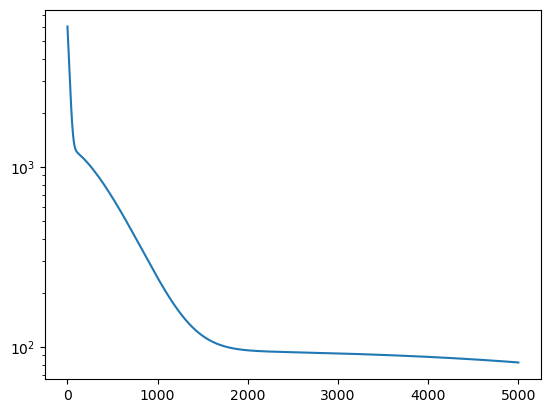

In [340]:
plt.plot(np.array(losses_p)[:,0] + np.array(losses_p)[:,1])
plt.yscale('log')

In [293]:
loss(pinn, pattern.t_star[-1:].astype(np.float32),
     #pattern.params["D_u"], pattern.params["D_v"],
     pattern.params["rho_u"], pattern.params["rho_v"],
     pattern.params["sigma_u"], pattern.params["sigma_v"],
     pattern.params["mu_u"], pattern.params["kappa_u"], 
                      )

(<tf.Tensor: shape=(), dtype=float32, numpy=204.53876>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.6726049>)

In [320]:
delta_1 = 0.001
delta_2 = 0.01
param1 = "rho_u"
param2 = "sigma_u"
param1_value = pattern.params[param1]
param2_value = pattern.params[param2]
#r_1 = np.linspace(param1_value-delta_1, param1_value+delta_1, 10)
r_1 = np.linspace(.9, 2.0, 30)
r_2 = np.linspace(.9, 2.4, 30)

f_us = np.zeros((r_1.shape[0], r_2.shape[0]))
f_vs = np.zeros((r_1.shape[0], r_2.shape[0]))

for i, v1 in enumerate(r_1):
    for j, v2 in enumerate(r_2):
#         f_u, f_v = loss(pinn, pattern.t_star[-1:].astype(np.float32),
#      #pattern.params["D_u"], pattern.params["D_v"],
#      v1,#pattern.params["rho_u"], 
#      pattern.params["rho_v"],
#      v2,#pattern.params["sigma_u"], 
#      pattern.params["sigma_v"],
#      pattern.params["mu_u"], pattern.params["kappa_u"], 
#                       )
        f_u = loss_u(pinn, pattern.t_star[-1:].astype(np.float32),
                         v1,
                         v2,     
                         pattern.params["mu_u"], 
                        pattern.params["kappa_u"], 
                      )
        f_us[i,j] = f_u.numpy()
        #f_vs[i,j] = f_v.numpy()

In [324]:
pattern.params["mu_u"],pattern.params["kappa_u"]

(1.0, 0.0)

In [329]:
loss_u(pinn, pattern.t_star[-1:].astype(np.float32),
                         1.81295509, 2.28240346,     
       1.80878956,
                         #pattern.params["mu_u"], 
                      0.001  #pattern.params["kappa_u"], 
                      )

<tf.Tensor: shape=(), dtype=float32, numpy=2197.5286>

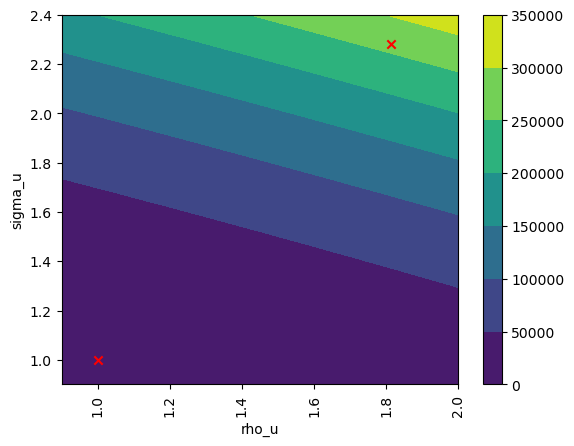

In [321]:
plt.contourf(r_1, r_2,f_us)
plt.colorbar()
plt.xlabel(param1)
plt.ylabel(param2)
plt.scatter(param1_value, param2_value,c ='r', marker='x')
#plt.scatter(rho_u.numpy(), sigma_u.numpy(),c ='r', marker='x')
plt.scatter(1.81295509, 2.28240346,c ='r', marker='x')
#plt.plot(samples[0,0:], samples[1,0:])
#plt.scatter(samples[0,0], samples[1,0],c ='r', marker='o')
#plt.scatter(rho_u2.numpy(), sigma_u2.numpy(),c ='r', marker='x')
plt.xticks(rotation = 90)
plt.show()

In [100]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 1.0,
 'mu_u': 1.0,
 'sigma_u': 1.0,
 'rho_v': 0.025,
 'sigma_v': 0.1}

In [294]:
def minimize_parameters(pinn, ts, method="Powell", tol=1e-7, **kwargs):

    initial_parameters = (pattern.params["rho_u"], pattern.params["rho_v"],
                          pattern.params["sigma_u"], pattern.params["sigma_v"],
                          pattern.params["mu_u"], pattern.params["kappa_u"])
    

    def minimize_model_parameters(args):        
        fu, fv = loss(pinn, ts,*args)
        #print(fu.numpy(), fv.numpy())
        return fu.numpy() + fv.numpy()

    return minimize(minimize_model_parameters, initial_parameters, method=method, tol=tol, **kwargs)

In [295]:
ret = minimize_parameters(pinn, pattern.t_star[-1:].astype(np.float32), options={'maxiter':10})
ret

204.53876 1.6726049
204.53876 1.6726049
197286.38 1.6726049
482144.62 1.6726049
204.53876 1.6726049
67450.445 1.6726049
30854.64 1.6726049
119.21233 1.6726049
119.21235 1.6726049
119.218925 1.6726049
119.2133 1.6726049
119.21252 1.6726049
119.21238 1.6726049
119.21235 1.6726049
119.21234 1.6726049
119.21235 1.6726049
119.21234 1.6726049
119.21234 1.6726049
119.21233 1.6726049
119.21233 189538.38
119.21233 494150.12
119.21233 1.6726049
119.21233 71910.734
119.21233 27769.79
119.21233 1.3583155
119.21233 1.3583156
119.21233 1.3583155
119.21233 1.4041713
119.21233 1.3650064
119.21233 1.359292
119.21233 1.3584582
119.21233 1.3583364
119.21233 1.3583186
119.21233 1.358316
119.21233 1.3583168
119.21233 1.3583174
119.21233 1.3583179
119.21233 1.3583181
119.21233 1.3583183
119.21233 1.3583186
119.21233 1.3583182
119.21233 1.3583182
119.21233 1.3583181
119.21233 1.3583181
119.21233 1.3583181
9190.277 1.3583181
26959.625 1.3583181
119.21233 1.3583181
4313.9863 1.3583181
1270.3481 1.3583181
105.6

16.404396 0.36877343
16.404396 0.36877343
16.404396 0.36877343
47.179802 0.3121903
104.107056 1.1439574
16.404396 0.36877343
29.321583 0.55707973
20.735466 0.31258988
16.399448 0.36507356
16.399006 0.36542228
16.399006 0.365416
16.399162 0.3652791
16.399063 0.36536375
16.399033 0.3653922
16.399021 0.36540693
16.39901 0.36541247
16.399014 0.36541414
16.399017 0.36541033
16.399014 0.3654117
16.399017 0.3654132
16.399014 0.36541224
16.39901 0.3654127
16.39901 0.36541244
16.399014 0.36541227
16.39901 0.36541247
16.39901 0.36541247
48.130287 0.32440972
16.39901 0.36541247
175372.9 0.36541247
459200.12 0.36541247
16.39901 0.36541247
67018.91 0.36541247
25595.316 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 0.36541247
16.398304 175459.72
16.398304 459017.72
16.398304 0.36541247
16.398304 66939.336
16.398304 25

15.717696 0.4307662
15.717699 0.43076506
15.7176895 0.43077716
15.717691 0.43077046
15.717692 0.43076822
15.717692 0.43076822
15.717693 0.4307682
15.717692 0.43076822
15.717692 9774.609
15.717692 25703.18
15.717692 0.43076822
15.717692 3760.6562
15.717692 1420.1322
15.717692 0.4124176
15.717692 0.41241753
15.717692 0.41241756
15.717692 0.41509506
15.717692 0.41280827
15.717692 0.41247457
15.717692 0.41242588
15.717692 0.41241878
15.717692 0.4124177
15.717692 0.412418
15.717692 0.41241825
15.717692 0.41241845
15.717692 0.41241813
15.717692 0.4124181
15.717692 0.41241807
15.717692 0.41241807
15.717692 0.412418
15.717692 0.41241804
15.717692 0.41241804
15.717692 0.41241804
15.717692 0.412418
15.717692 0.412418
259415.66 0.412418
679326.44 0.412418
15.717692 0.412418
99143.19 0.412418
37850.93 0.412418
15.715703 0.412418
15.715702 0.412418
15.715703 0.412418
15.715702 0.412418
15.715702 0.412418
15.715702 0.412418
15.715702 0.412418
15.715702 0.412418
15.715702 0.412418
15.715702 0.412418


13.364909 0.29006407
13.364909 0.29006407
13.373253 0.29006407
13.366127 0.29006407
13.365089 0.29006407
13.364936 0.29006407
13.364914 0.29006407
13.364912 0.29006407
13.364908 0.29006407
13.364912 0.29006407
13.364911 0.29006407
13.364909 0.29006407
13.364908 0.29006407
13.364908 0.29006407
13.364908 0.29006407
13.364908 0.29006407
13.364908 0.29006407
13.364908 0.29006407
13.364908 0.29006407
13.497535 0.61053085
13.589036 0.8803005
13.364908 0.29006407
13.386312 0.35119212
13.391226 0.35187632
13.362854 0.28628138
13.362855 0.28628317
13.362873 0.2862744
13.36286 0.28627706
13.362854 0.2862792
13.362855 0.28627914
13.362855 0.28627917
13.362855 0.2862792
13.362855 0.28627917
13.362856 0.2862792
13.362854 0.2862792
13.362854 0.2862792
13.73557 0.30099687
13.951139 0.329368
13.362854 0.2862792
13.411472 0.2928448
13.4398985 0.2882343
13.354819 0.2868098
13.354815 0.28681344
13.354805 0.2868273
13.354807 0.2868187
13.354806 0.286822
13.354812 0.2868177
13.354809 0.28681993
13.354808 0

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.63661280e-03, -3.27439527e-03, -1.27854806e-02,
        -1.30635951e-02, -1.21896246e-03,  7.80719546e-05],
       [ 6.46161166e-03, -7.46676694e-04, -2.41734867e-02,
        -2.94799287e-03, -1.46202863e-03,  5.99448310e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.54320198e-02,  3.56286955e-03, -6.05180383e-02,
         1.28743365e-02,  4.66091857e-03,  4.62428446e-04]])
     fun: 13.628745
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1470
     nit: 10
  status: 2
 success: False
       x: array([1.06128484, 0.0209626 , 1.01308048, 0.08045187, 1.01700987,
       0.00173593])

In [ ]:
'rho_u': 1.0, 'rho_v': 0.025, 'sigma_u': 1.0, 'sigma_v': 0.1, 'mu_u': 1.0, 'kappa_u': 0.0

In [127]:
print('rho_u', rho_u.numpy(), 'rho_v', rho_v.numpy(), 'sigma_u',sigma_u.numpy(),'sigma_v', sigma_v.numpy(), 
      'mu_u', mu_u.numpy(), 'kappa_u', kappa_u.numpy())

rho_u 1.7957288 rho_v 0.021893924 sigma_u 2.247273 sigma_v 0.08130709 mu_u 1.7878075 kappa_u 0.0027243712


In [305]:
def minimize_parameters_u(pinn, ts, method="Powell", tol=1e-7, **kwargs):

    initial_parameters = (pattern.params["rho_u"], pattern.params["sigma_u"], 
                          pattern.params["mu_u"], pattern.params["kappa_u"])
    

    def minimize_model_parameters(args):        
        fu = loss_u(pinn, ts,*args)
        #print(fu.numpy())
        return fu.numpy()

    return minimize(minimize_model_parameters, initial_parameters, method=method, tol=tol, **kwargs)

def minimize_parameters_v(pinn, ts, method="Powell", tol=1e-7, **kwargs):

    initial_parameters = ( pattern.params["rho_v"],  pattern.params["sigma_v"],
                          pattern.params["kappa_u"])
    

    def minimize_model_parameters(args):        
        fv = loss_v(pinn, ts,*args)
        #print(fv.numpy())
        return fv.numpy()

    return minimize(minimize_model_parameters, initial_parameters, method=method, tol=tol, **kwargs)

In [306]:
ret_u = minimize_parameters_u(pinn, pattern.t_star[-1:].astype(np.float32), 
                              options={'maxiter':100})
ret_u

   direc: array([[3.22532988e-01, 6.77400982e-01, 3.75342943e-01, 9.16228528e-05],
       [6.04403726e-02, 2.42965420e-02, 4.43165253e-02, 1.71465369e-04],
       [3.63755357e-02, 3.81212361e-02, 3.06687966e-02, 9.76047287e-05],
       [9.17459350e-03, 1.52399005e-02, 9.65294420e-03, 6.59947036e-06]])
     fun: 1.8355231
 message: 'Optimization terminated successfully.'
    nfev: 2211
     nit: 20
  status: 0
 success: True
       x: array([1.81295509, 2.28240346, 1.80878956, 0.00269907])

In [307]:
ret_v = minimize_parameters_v(pinn, pattern.t_star[-1:].astype(np.float32), options={'maxiter':100})
ret_v

   direc: array([[ 0.0012023 , -0.00433337,  0.00209511],
       [ 0.00154496,  0.00322475,  0.00101244],
       [ 0.00021203,  0.00039702,  0.0001169 ]])
     fun: 0.24218823
 message: 'Optimization terminated successfully.'
    nfev: 816
     nit: 10
  status: 0
 success: True
       x: array([0.02801395, 0.0939617 , 0.00668746])

In [314]:
loss_u(pinn, pattern.t_star[-1:].astype(np.float32),
   1.81295509, 2.28240346, 1.80878956, 0.00269907)

<tf.Tensor: shape=(), dtype=float32, numpy=1.8355241>